<h1>Import all libraries and reading explored data into Dataframe</h1>

In [2]:
import re
import io

#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing

#Libraries for data pre-processing (Log Loss)
from sklearn.datasets import make_blobs
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

#For Decision Tree implementation
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#For KNN implementation
from sklearn.neighbors import KNeighborsClassifier

#For Bagging implementation
from sklearn.ensemble import BaggingClassifier

#For AdaBoost implementation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

#For Random Forest implementation
from sklearn.ensemble import RandomForestClassifier

#For Baseline implementation
from sklearn.dummy import DummyClassifier

#For Logistic Regression
from sklearn.linear_model import LogisticRegression

#For Ensemble
from sklearn.ensemble import VotingClassifier

#Settings
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(threshold=np.nan)
sns.set()

def printModelAccuracy(y_test, y_pred):
    # Find the confusion matrix of the result
    cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1, 2, 3, 4, 5]), \
        index=['true:1', 'true:2', 'true:3', 'true:4', 'true:5'], 
        columns=['pred:1', 'pred:2', 'pred:3', 'pred:4', 'pred:5'])
    print("Confusion Matrix:")
    print(cm)

    # Find the accuracy and F1 score of the result
    asr = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print("Accuracy:", asr)
    print("F1:", f1)
    """
    # Log loss
    score = log_loss(y_test, y_pred)
    print("Log Loss:", score)
    """
    
# Read from dataframe
df = pd.read_pickle("explored_data")
df = df.replace([np.inf, -np.inf, np.nan], 0) #removing infinite/nan values

# Check the columns using dtypes
print(df.dtypes)
# Randomly sample 5 records with .sample(5)
df.sample(5)

budget                 float64
revenue                float64
weekday                float64
day                    float64
month                  float64
year                   float64
runtime                float64
vote_average           float64
vote_count             float64
weighted_rating        float64
bin                    float64
log_revenue            float64
log_budget             float64
log_runtime            float64
log_vote_count         float64
log_vote_average       float64
log_weighted_rating    float64
dtype: object


,budget,revenue,weekday,day,month,year,runtime,vote_average,vote_count,weighted_rating,bin,log_revenue,log_budget,log_runtime,log_vote_count,log_vote_average,log_weighted_rating
12725,0.00,2281569.00,4.00,15.00,2.00,1990.00,92.00,6.70,10.00,7.00,3.00,14.64,0.00,4.52,2.30,1.90,1.95
9122,0.00,2300.00,5.00,8.00,4.00,2016.00,70.00,5.00,13.00,7.00,1.00,7.74,0.00,4.25,2.56,1.61,1.95
9577,2000000.00,661946.00,7.00,1.00,1.00,2012.00,30.00,10.00,1.00,7.00,3.00,13.40,14.51,3.40,0.00,2.30,1.95
1802,0.00,1144438.00,2.00,10.00,4.00,2007.00,14.00,0.00,0.00,7.00,3.00,13.95,0.00,2.64,0.00,0.00,1.95
9647,0.00,100600.00,5.00,30.00,1.00,2015.00,85.00,0.00,2.00,7.00,2.00,11.52,0.00,4.44,0.69,0.00,1.95


In [3]:
#Decision Tree in SKLearn don't take in string well. So we use a label encoder to change that string to a numeric value
"""
for column in df.columns:
    if df[column].dtype == type(object):
        #Create the label encoder
        le = preprocessing.LabelEncoder()
        #Convert the non numeric data to numeric
        df[column] = le.fit_transform(df[column])
"""

'\nfor column in df.columns:\n    if df[column].dtype == type(object):\n        #Create the label encoder\n        le = preprocessing.LabelEncoder()\n        #Convert the non numeric data to numeric\n        df[column] = le.fit_transform(df[column])\n'

<h1>Find out the number of records per revenue bin. </h1>

   bin     n
0 1.00  3502
1 2.00  3500
2 3.00  3502
3 4.00  3502
4 5.00  3505


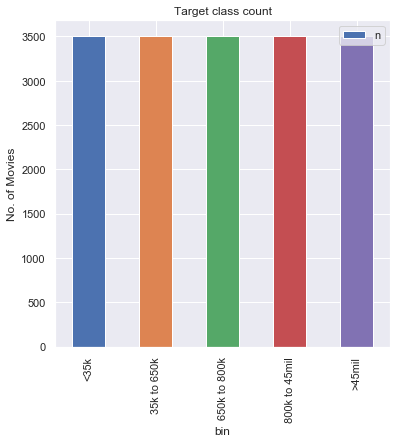

In [2]:
# Using groupby, find out the number of reviews with
# positive and negative sentiment respectively.
df_target = df.groupby('bin').size().reset_index(name='n')
print(df_target)

# How many patients in the dataset have been diagnosed positive and negative for diabetes?
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
df_target.plot(kind='bar', x='bin', y='n', title = "Target class count", ax=ax1)
ax1.set_ylabel("No. of Movies")
plt.xticks(np.arange(0,5), ["<35k", "35k to 650k", "650k to 800k", "800k to 45mil", ">45mil"])
plt.show()

<h1>Train-Test Split</h1>

In [3]:
#X = df.loc[:, df.columns != 'bin']
X = df[['budget', 'weekday', 'day', 'month', 'year', 'runtime', 'weighted_rating']]
#X = df[['log_budget', 'weekday', 'day', 'month', 'year', 'log_runtime', 'log_weighted_rating']]
y = df[['bin']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

<h1>Baseline Classifier (Decision Tree)</h1>

In [39]:
parameters = {
    'max_depth' : list(range(5, 10))
}

decisionTree = GridSearchCV(DecisionTreeClassifier(), cv=3, param_grid=parameters)
#Fit the training feature Xs and training label Ys
decisionTree.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = decisionTree.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

# Best hyperparameters to use for model
print("Best Parameters:",decisionTree.best_params_)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     402     206      67      11       5
true:2     329     284      77      22       6
true:3     183     287     118      88      22
true:4     117     164      81     199     106
true:5      69     105      24     150     381
Accuracy: 0.39508992292320866
F1: 0.3905269955189576
Best Parameters: {'max_depth': 8}


<h1>1. k-Nearest Neighbor (KNN)</h1>

Refer to the following links on for detail explanation on the implementation:
- [kNN Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [DataCamp Implementation](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)



In [13]:
#Create the kNN classifier and set the number of neighbors. Note that you can tune this number of neighbors
knn = KNeighborsClassifier()

parameters = {'n_neighbors':list(range(1, 10)),
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

#Fit the training feature Xs and training label Ys
knn = GridSearchCV(
        knn, 
        cv=3, 
        param_grid=parameters, 
        scoring='f1_macro')

knn.fit(X_train,y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = knn.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

# Best hyperparameters to use for model
print("Best Parameters:",knn.best_params_)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     342     172     112      53      12
true:2     286     224     133      59      16
true:3     192     191     173     107      35
true:4     131     117     124     186     109
true:5      62      69      70     159     369
Accuracy: 0.3693976591493006
F1: 0.3698591545261179
Best Parameters: {'algorithm': 'auto', 'leaf_size': 3, 'n_jobs': -1, 'n_neighbors': 9}


<h1>2. Bagging (with Decision Tree)</h1>

Refer to the following links on for detail explanation on the implementation:
- [Bagging Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

*Note that the default AdaBoost implementation in SKLearn is Decision Tree 

In [13]:
#Create the Bagging classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
parameters = {
    'base_estimator__max_depth' : list(range(5, 10)),
    'n_estimators' : [100, 200],
    'max_features' : [0.5, 0.6, 0.7],
    'max_samples' : [0.6, 0.7]
}

baggingTree = GridSearchCV(
                BaggingClassifier(DecisionTreeClassifier()), 
                cv=3,
                param_grid=parameters, 
                scoring='f1_macro')

#Fit the training feature Xs and training label Ys
baggingTree.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = baggingTree.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

# Best hyperparameters to use for model
print("Best Parameters:",baggingTree.best_params_)

C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\metrics\c

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     439     154      66      29       3
true:2     341     206     130      33       8
true:3     197     174     198     111      18
true:4     136      97     101     226     107
true:5      81      67      40     120     421
Accuracy: 0.42534970025692265
F1: 0.4227534407476826
Best Parameters: {'base_estimator__max_depth': 8, 'max_features': 0.6, 'max_samples': 0.7, 'n_estimators': 100}


<h1>3. Bagging (with kNN)</h1>

In [25]:
#Create the kNN base classifier
parameters = {
    'n_estimators' : [100, 200],
    'max_features' : [0.5, 0.6, 0.7],
    'max_samples' : [0.6, 0.7]
}

baggingknn = GridSearchCV(
                BaggingClassifier(KNeighborsClassifier(algorithm='auto', leaf_size=3, n_jobs=-1, n_neighbors=9)), 
                cv=3,
                param_grid=parameters, 
                scoring='f1_macro')

#Create the Bagging classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
#baggingknn = BaggingClassifier(n_estimators=50, base_estimator=knn)

#Fit the training feature Xs and training label Ys
baggingknn.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = baggingknn.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

# Best hyperparameters to use for model
print("Best Parameters:",baggingknn.best_params_)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     370     189      91      33       8
true:2     305     226     122      53      12
true:3     176     193     193     113      23
true:4     121     109     129     192     116
true:5      75      60      63     135     396
Accuracy: 0.3930916357407936
F1: 0.39293148950811585
Best Parameters: {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}


<h1>4. AdaBoost (with Decision Tree)</h1>

Refer to the following links on for detail explanation on the implementation:
- [AdaBoost Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
- [DataCamp Implementation](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)
- [Setting Learning Rate and N Estimators](https://stats.stackexchange.com/questions/82323/shrinkage-parameter-in-adaboost)

*Note that the default AdaBoost implementation in SKLearn is Decision Tree 


In [40]:
#Create the AdaBoost classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
# - learning_rate controls the weight adjustments of each base classifiers. Default is 1
# - learning_rate controls the weight adjustments of each base classifiers. Default is 1
parameters = {"base_estimator__max_depth" : list(range(5, 10)),
              "base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 50, 100, 200],
              "learning_rate": [1, 2]
             }

adaboostTree = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier()), cv=3, param_grid=parameters)

#Fit the training feature Xs and training label Ys
adaboostTree.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = adaboostTree.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)
print("Best Parameters:",adaboostTree.best_params_)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     402     206      67      11       5
true:2     329     284      77      22       6
true:3     183     287     119      87      22
true:4     117     164      82     199     105
true:5      69     105      23     152     380
Accuracy: 0.39508992292320866
F1: 0.3906740636178915
Best Parameters: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 8, 'base_estimator__splitter': 'best', 'learning_rate': 2, 'n_estimators': 1}


<h1>5. AdaBoost (with Gaussian Navie Bayes)</h1>

Refer to the following links on for detail explanation on the implementation:
- [Gaussian Naive Bayes Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [Naive Bayes Classifier video](https://www.youtube.com/watch?v=CPqOCI0ahss)

In [34]:
naivebayes = GaussianNB()
#Fit the training feature Xs and training label Ys
naivebayes.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = naivebayes.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     639      28      14      10       0
true:2     633      60      17       6       2
true:3     503      93      51      46       5
true:4     336      44      77     151      59
true:5     182      24      41     188     294
Accuracy: 0.3411361689980017
F1: 0.2977363014353807


In [35]:
nb = GaussianNB()

adaboostnaivebayes = AdaBoostClassifier(n_estimators=50,learning_rate=1, base_estimator=nb)
#model = BaggingClassifier(n_estimators=50, base_estimator=knn)

#Fit the training feature Xs and training label Ys
adaboostnaivebayes.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = adaboostnaivebayes.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1      59     604      12      15       1
true:2      67     610      15      22       4
true:3      67     514      35      73       9
true:4      34     430      73     119      11
true:5      15     318     111     182     103
Accuracy: 0.26434484727376534
F1: 0.20874901718791108


<h1>6. Random Forest</h1>

In [30]:
#Instantiate model
randomforest = RandomForestClassifier()

parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    'criterion' :['gini', 'entropy']
}

#Fit the training feature Xs and training label Ys
randomforest = GridSearchCV(randomforest, cv=3, param_grid=parameters, scoring='f1_macro')
randomforest.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = randomforest.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

# Best hyperparameters to use for model
print("Best Parameters:", randomforest.best_params_)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     498     106      66      17       4
true:2     412     144     129      26       7
true:3     275     115     206      84      18
true:4     180      53     121     176     137
true:5     108      43      43      94     441
Accuracy: 0.41821296031972593
F1: 0.4043495480364002
Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 500}


<h1>7. Logistic Regression</h1>

In [36]:
#create a new logistic regression model ‘lbfgs’, ‘sag’ and ‘newton-cg’ solvers.
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

#fit the model to the training data
log_reg.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = log_reg.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     647       8      15      18       3
true:2     646      17      30      20       5
true:3     523      20      54      86      15
true:4     336       9      38     150     134
true:5     186       4      16     119     404
Accuracy: 0.36311732800456753
F1: 0.30146062117306716


<h1>8. Ensemble (Stacking with all models)</h1>

As I mentioned in lecture, it is possible to ensemble different models. So how can we do that in python? Check out the following link and try it for your project!:
https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/ 

In [55]:
#knn with best parameters
knn = KNeighborsClassifier(algorithm='auto', leaf_size=3, n_jobs=-1, n_neighbors=9)
knn.fit(X_train,y_train.values.ravel())

#baggingTree with best parameters
baggingTree = BaggingClassifier(DecisionTreeClassifier(max_depth=8), max_features=0.7, max_samples=0.5, n_estimators=100)
baggingTree.fit(X_train, y_train.values.ravel())

#baggingknn with best parameters
baggingknn = BaggingClassifier(knn, max_features=0.5, max_samples=0.7, n_estimators=200)
baggingknn.fit(X_train, y_train.values.ravel())

#Adaboost(DecisionTree) with best parameters
adaboostTree = AdaBoostClassifier(DecisionTreeClassifier(criterion='gini', max_depth=8, splitter='best'), learning_rate=2, n_estimators=1)
adaboostTree.fit(X_train, y_train.values.ravel())

#random forest with best parameters
randomforest = RandomForestClassifier(criterion='gini', max_depth=6, max_features='log2', n_estimators=500)
randomforest.fit(X_train, y_train.values.ravel())

#create a dictionary of our models
estimators=[('knn', knn), 
            ('baggingTree', baggingTree),
            ('baggingknn', baggingknn),
            ('adaboostTree', adaboostTree),
            #('naivebayes', naivebayes),
            #('adaboostnaivebayes', adaboostnaivebayes),
            ('randomforest', randomforest), 
            ('log_reg', log_reg)]

#create our voting classifier, inputting our models, voting hard means asking classifers to make predictions by majority vote
ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(X_train, y_train.values.ravel())

#Use the trained model to predict the test data
y_pred = ensemble.predict(X_test)

# Find the confusion matrix, the accuracy, and F1 score of the result
printModelAccuracy(y_test, y_pred)

Confusion Matrix:
        pred:1  pred:2  pred:3  pred:4  pred:5
true:1     538      86      50      15       2
true:2     483     120      87      22       6
true:3     311     118     173      85      11
true:4     207      59     100     203      98
true:5     121      42      39     126     401
Accuracy: 0.4096488723950899
F1: 0.3951199712853787
